In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.path.append("/export/raid1/home/styvesg/code/")

import nsd_gnet8x.src.numpy_utility as pnu
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from nsd_gnet8x.src.config import *

from src.utility import *
from src.sampler import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.2+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [4]:
output_dir = root_dir + 'output/'

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

# Reload stim and labels

In [6]:
subjects = [1,2,3,4,5,6,7,8]

In [7]:
from nsd_gnet8x.src.load_nsd import image_feature_fn

stim_data = {}
for s in subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    stim_data[s] = image_feature_fn(np.copy(image_data_set['stimuli']))
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', stim_data[s].shape, ', dtype:', stim_data[s].dtype, ', value range:',\
           np.min(stim_data[s][0]), np.max(stim_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0


In [8]:
cat_data = {}
for s in subjects: 
    cat_data_set = h5py.File(stim_dir + "S%d_supercategory_227.h5py"%s, 'r')
    cat_data[s] = embed_dict({s: np.copy(d) for s,d in cat_data_set.items()})
    cat_data_set.close()
    print ('--------  subject %d  -------' % s)
    print (cat_data[s].keys())
    #print ('block size:', stim_data[s].shape, ', dtype:', stim_data[s].dtype, ', value range:',\
    #       np.min(stim_data[s][0]), np.max(stim_data[s][0]))

--------  subject 1  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 2  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 3  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 4  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 5  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 6  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 7  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 8  -------
dict_keys(['label_count', 'label_map', 'labels'])


## Things supercategory: outdoor food indoor appliance kitchen sports person animal vehicle accessory electronic furniture

In [9]:
thing_label_index = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
thing_labelmap = {int(i): ('%s' % cat_data[1]['label_map']['%d'%i])[2:-1] for i in thing_label_index}

In [10]:
print (thing_labelmap)

{0: 'appliance', 1: 'accessory', 2: 'kitchen', 3: 'furniture', 4: 'indoor', 5: 'outdoor', 6: 'vehicle', 7: 'electronic', 8: 'sports', 9: 'food', 10: 'person', 11: 'animal'}


In [11]:
things_mh = {s: np.zeros(shape=(len(cat_data[s]['labels']), len(thing_label_index))) for s in subjects}
for s in subjects:
    for k,lim in enumerate(cat_data[s]['labels']):
        uni = np.unique(lim)
        uni_thing = intersection(uni, thing_label_index)
        things_mh[s][k, uni_thing] = 1 # this only works because the index are already a minimal set starting at zero

In [12]:
# there needs to be some filtering for incomplete samples
print ( things_mh[1].shape)

(10000, 12)


Minimum #samples = 686


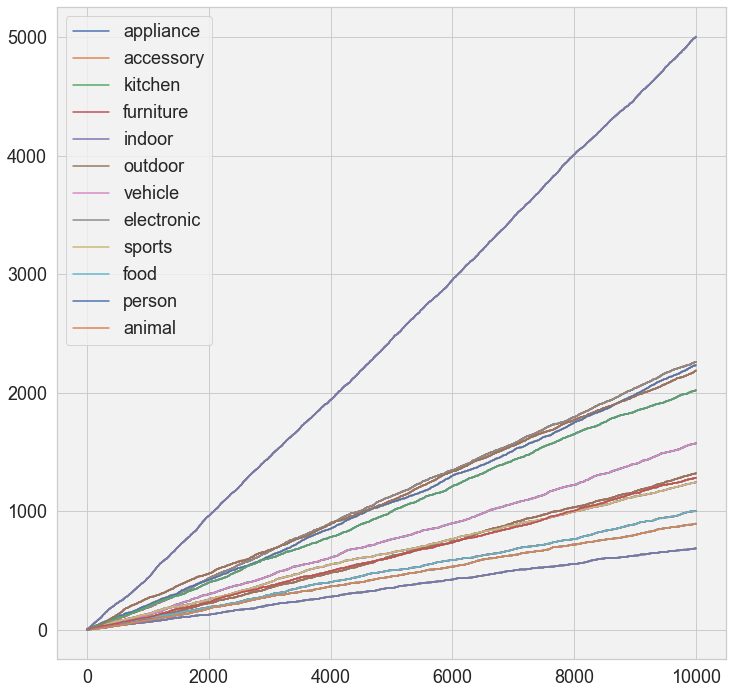

In [13]:
plt.figure(figsize=(12,12))
ymin = np.inf
for s in subjects:
    for k in thing_label_index:
        y = np.cumsum(things_mh[1][:,k], axis=0)
        if y[-1]<ymin:
            ymin = y[-1]
        plt.plot(y, label=thing_labelmap[k] if s==1 else None)
plt.legend(loc='upper left')
print ('Minimum #samples = %d'%ymin)

Main label:  person


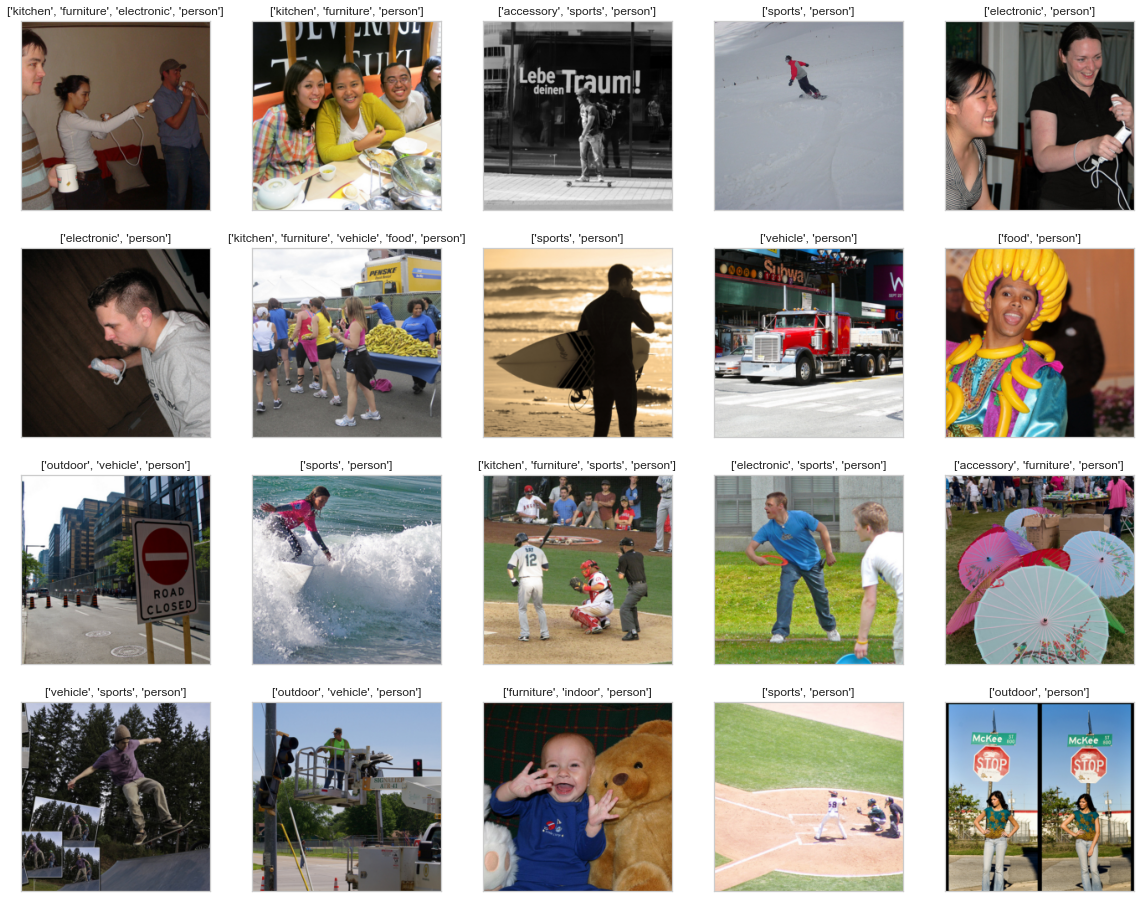

In [15]:
subj = 1
a_thing = 10
n_start = 0
n_img = 20
n_row = 4
print ('Main label: ', thing_labelmap[a_thing])
thing_sample_indices = get_n_random_thing_samples(things_mh, subj, a_thing, 100)
plt.figure(figsize=(4*int(np.ceil(float(n_img)/n_row)), 4*n_row))
for k,i in enumerate(range(n_start, n_start+n_img)):
    j = thing_sample_indices[i]
    
    plt.subplot(n_row, int(np.ceil(float(n_img)/n_row)), k+1)
    plt.imshow(stim_data[subj][j].transpose(1,2,0))
    plt.grid(False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    
    im_label = thing_label_index[things_mh[subj][j].astype(bool)]
    plt.title([thing_labelmap[lab] for lab in im_label], fontsize=12)

# Network trained parameter source

In [17]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))

def iterate_range(start, length, batchsize):
    batch_count = int(length // batchsize )
    residual = int(length % batchsize)
    for i in range(batch_count):
        yield range(start+i*batchsize, start+(i+1)*batchsize),batchsize
    if(residual>0):
        yield range(start+batch_count*batchsize,start+length),residual 

# Alexnet

In [18]:
import torch as T
from src.geometry import k_rand_label_index, geometry, PCA_geometry, prD
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net
from torchvision.models import alexnet

n_samples = 9
batchsize = 100
K = 12
V = 2000
## WEIRD, Alexnet with:
 # pretrained=False, shuffle=True, WORKS
 # pretrained=True, shuffle=True, DOESNT WORK
model_name = 'alexnet-rc'
shuffle_params = False

_x = torch.tensor(stim_data[1][:100]).to(device) # the input variable.
anet = alexnet(pretrained=True).to(device)
anet_dict = analyse_net(anet, quiet=True)
_fmaps_fn = fmapper(anet_dict, [2, 4, 7, 9, 11, 17, 20, 21]).to(device)
_fmaps = _fmaps_fn(_x)    
   
feature_embs, labels = {}, {}
for s in tqdm(np.arange(n_samples)):
    ##
    if shuffle_params:
        for _p in anet.parameters():
            p = get_value(_p).flatten()
            np.random.shuffle(p)
            set_value(_p, p.reshape(_p.size()))
        anet.eval()
    ##
    feature_maps = {}
    rs = subjects[np.random.randint(len(subjects))] # random set of images, if more than one
    for k,_fm in enumerate(_fmaps):       
        feature_maps[k] = np.zeros(shape=(len(stim_data[rs]),)+tuple(_fm.size()[1:]), dtype=np.float32)
    for rr, rl in iterate_range(0, len(stim_data[rs]), batchsize):
        _x = torch.tensor(stim_data[rs][rr]).to(device) # the input variable.
        _fmaps = _fmaps_fn(_x)
        for k,_fm in enumerate(_fmaps):
            feature_maps[k][rr] = get_value(_fm) 
    ##  zscore      
    for k,fm in feature_maps.items():
        ffm = fm.reshape((fm.shape[0], -1))
        feature_maps[k] = ffm
        feature_maps[k] = ffm - np.mean(ffm, axis=0, keepdims=True)
        feature_maps[k] /= np.std(ffm, axis=0, keepdims=True) + 1e-6
        print (feature_maps[k].shape)
    ##
    sampler = Subsampler(random_subspace=20000, random_projections=V)
    feature_embs[s] = sampler.apply(feature_maps)    
    labels[s] = things_mh[rs]

  0%|          | 0/9 [00:00<?, ?it/s]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 11%|█         | 1/9 [01:20<10:47, 80.90s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 22%|██▏       | 2/9 [02:42<09:27, 81.08s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 33%|███▎      | 3/9 [04:03<08:06, 81.14s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 44%|████▍     | 4/9 [05:24<06:45, 81.13s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 56%|█████▌    | 5/9 [06:45<05:24, 81.23s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 67%|██████▋   | 6/9 [08:07<04:03, 81.22s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 78%|███████▊  | 7/9 [09:28<02:42, 81.30s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


 89%|████████▉ | 8/9 [10:49<01:21, 81.11s/it]

(10000, 46656)
(10000, 139968)
(10000, 64896)
(10000, 43264)
(10000, 43264)
(10000, 4096)
(10000, 4096)
(10000, 1000)


100%|██████████| 9/9 [12:10<00:00, 81.20s/it]


In [19]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 13.96it/s]


In [25]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Nsa.0 in h5py file
saved 0.Nsa.1 in h5py file
saved 0.Nsa.2 in h5py file
saved 0.Nsa.3 in h5py file
saved 0.Nsa.4 in h5py file
saved 0.Nsa.5 in h5py file
saved 0.Nsa.6 in h5py file
saved 0.Nsa.7 in h5py file
saved 0.Nsb.0 in h5py file
saved 0.Nsb.1 in h5py file
saved 0.Nsb.2 in h5py file
saved 0.Nsb.3 in h5py file
saved 0.Nsb.4 in h5py file
saved 0.Nsb.5 in h5py file
saved 0.Nsb.6 in h5py file
saved 0.Nsb.7 in h5py file
saved 0.Nss.0 in h5py file
saved 0.Nss.1 in h5py file
saved 0.Nss.2 in h5py file
saved 0.Nss.3 in h5py file
saved 0.Nss.

saved 5.SNR.0 in h5py file
saved 5.SNR.1 in h5py file
saved 5.SNR.2 in h5py file
saved 5.SNR.3 in h5py file
saved 5.SNR.4 in h5py file
saved 5.SNR.5 in h5py file
saved 5.SNR.6 in h5py file
saved 5.SNR.7 in h5py file
saved 5.m in h5py file
saved 5.P in h5py file
saved 6.Sign.0 in h5py file
saved 6.Sign.1 in h5py file
saved 6.Sign.2 in h5py file
saved 6.Sign.3 in h5py file
saved 6.Sign.4 in h5py file
saved 6.Sign.5 in h5py file
saved 6.Sign.6 in h5py file
saved 6.Sign.7 in h5py file
saved 6.Bias.0 in h5py file
saved 6.Bias.1 in h5py file
saved 6.Bias.2 in h5py file
saved 6.Bias.3 in h5py file
saved 6.Bias.4 in h5py file
saved 6.Bias.5 in h5py file
saved 6.Bias.6 in h5py file
saved 6.Bias.7 in h5py file
saved 6.Nsa.0 in h5py file
saved 6.Nsa.1 in h5py file
saved 6.Nsa.2 in h5py file
saved 6.Nsa.3 in h5py file
saved 6.Nsa.4 in h5py file
saved 6.Nsa.5 in h5py file
saved 6.Nsa.6 in h5py file
saved 6.Nsa.7 in h5py file
saved 6.Nsb.0 in h5py file
saved 6.Nsb.1 in h5py file
saved 6.Nsb.2 in h5p

In [33]:
plot_roi = np.arange(len(_fmaps))

from matplotlib import cm
subj_cmap = {k: cm.get_cmap('rainbow', n_samples+1)(k+1) for k in range(n_samples)}

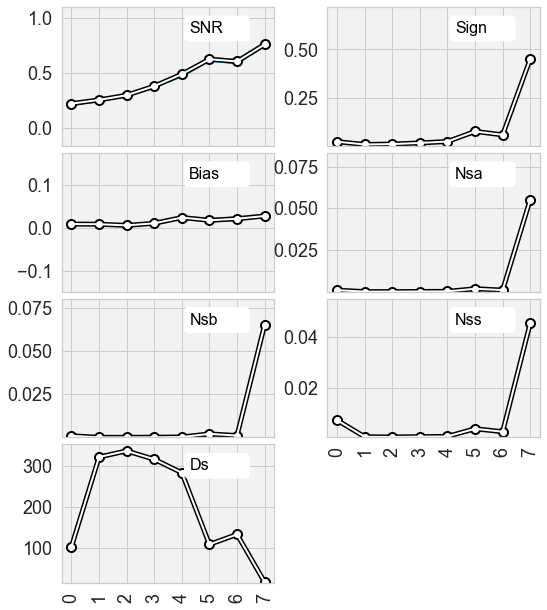

In [23]:
from src.plots import plot_SNR_summary

fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.25, hspace=0.05)
plot_SNR_summary(manifold_SNR, subj_cmap, plot_roi, perc_cutoff=25, fs=16)

---
# VGG19

In [26]:
import torch as T
from torchvision.models import vgg19

_x = torch.tensor(stim_data[subj][:100]).to(device) # the input variable.
vg19 = vgg19(pretrained=True).to(device)

from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net

vg19_dict = analyse_net(vg19, quiet=False)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [ ]:
import torch as T
from src.geometry import k_rand_label_index, geometry, PCA_geometry, prD
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net
from torchvision.models import alexnet

n_samples = 9
batchsize = 100
keep_N = 20000
V = 2000
model_name = 'vgg19-rc'
shuffle_params = False

_x = torch.tensor(stim_data[1][:100]).to(device) # the input variable.
vg19 = vgg19(pretrained=True).to(device)
vg19_dict = analyse_net(vg19, quiet=True)
_fmaps_fn = fmapper(vg19_dict, [1, 3, 6, 8, 11, 13, 15, 17, 20, 22, 24, 26, 29, 31, 33, 35, 40, 43, 45]).to(device)
_fmaps = _fmaps_fn(_x) 

feature_embs, labels = {}, {}
for s in tqdm(np.arange(n_samples)):
    ##
    if shuffle_params:
        for _p in anet.parameters():
            p = get_value(_p).flatten()
            np.random.shuffle(p)
            set_value(_p, p.reshape(_p.size()))
        anet.eval()
    ##
    feature_maps = {}
    rs = subjects[np.random.randint(len(subjects))] # random set of images, if more than one
    for k,_fm in enumerate(_fmaps):
        nf =  np.prod(_fm.size()[1:])
        print (_fm.size(), '-->', nf)
        idx = np.arange(nf)
        np.random.shuffle(idx)
        if nf<keep_N:
            keep_idxes += [idx,]
        else:
            keep_idxes += [idx[:keep_N],]    
    ##
    feature_maps = {}
    keep_idxes = []
    for k,(idx, _fm) in enumerate(zip(keep_idxes, _fmaps)):       
        feature_maps[k] = np.zeros(shape=(len(stim_data[rs]), len(idx)), dtype=np.float32)
    for rr, rl in iterate_range(0, len(stim_data[rs]), batchsize):
        _x = torch.tensor(stim_data[rs][rr]).to(device) # the input variable.
        _fmaps = _fmaps_fn(_x)
        for k,(idx,_fm) in enumerate(zip(keep_idxes, _fmaps)):
            _fm = T.flatten(_fm, start_dim=1)[:,idx]
            feature_maps[k][rr] = get_value(_fm)
    ##  zscore      
    for k,fm in feature_maps.items():
        ffm = fm.reshape((fm.shape[0], -1))
        feature_maps[k] = ffm
        feature_maps[k] = ffm - np.mean(ffm, axis=0, keepdims=True)
        feature_maps[k] /= np.std(ffm, axis=0, keepdims=True) + 1e-6
        print (feature_maps[k].shape)
    ##
    sampler = Subsampler(random_projections=V)
    feature_embs[s] = sampler.apply(feature_maps)    
    labels[s] = things_mh[rs]

In [19]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 13.96it/s]


In [25]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Nsa.0 in h5py file
saved 0.Nsa.1 in h5py file
saved 0.Nsa.2 in h5py file
saved 0.Nsa.3 in h5py file
saved 0.Nsa.4 in h5py file
saved 0.Nsa.5 in h5py file
saved 0.Nsa.6 in h5py file
saved 0.Nsa.7 in h5py file
saved 0.Nsb.0 in h5py file
saved 0.Nsb.1 in h5py file
saved 0.Nsb.2 in h5py file
saved 0.Nsb.3 in h5py file
saved 0.Nsb.4 in h5py file
saved 0.Nsb.5 in h5py file
saved 0.Nsb.6 in h5py file
saved 0.Nsb.7 in h5py file
saved 0.Nss.0 in h5py file
saved 0.Nss.1 in h5py file
saved 0.Nss.2 in h5py file
saved 0.Nss.3 in h5py file
saved 0.Nss.

saved 5.SNR.0 in h5py file
saved 5.SNR.1 in h5py file
saved 5.SNR.2 in h5py file
saved 5.SNR.3 in h5py file
saved 5.SNR.4 in h5py file
saved 5.SNR.5 in h5py file
saved 5.SNR.6 in h5py file
saved 5.SNR.7 in h5py file
saved 5.m in h5py file
saved 5.P in h5py file
saved 6.Sign.0 in h5py file
saved 6.Sign.1 in h5py file
saved 6.Sign.2 in h5py file
saved 6.Sign.3 in h5py file
saved 6.Sign.4 in h5py file
saved 6.Sign.5 in h5py file
saved 6.Sign.6 in h5py file
saved 6.Sign.7 in h5py file
saved 6.Bias.0 in h5py file
saved 6.Bias.1 in h5py file
saved 6.Bias.2 in h5py file
saved 6.Bias.3 in h5py file
saved 6.Bias.4 in h5py file
saved 6.Bias.5 in h5py file
saved 6.Bias.6 in h5py file
saved 6.Bias.7 in h5py file
saved 6.Nsa.0 in h5py file
saved 6.Nsa.1 in h5py file
saved 6.Nsa.2 in h5py file
saved 6.Nsa.3 in h5py file
saved 6.Nsa.4 in h5py file
saved 6.Nsa.5 in h5py file
saved 6.Nsa.6 in h5py file
saved 6.Nsa.7 in h5py file
saved 6.Nsb.0 in h5py file
saved 6.Nsb.1 in h5py file
saved 6.Nsb.2 in h5p

---
## ResNet50

In [38]:
import torch as T
from src.geometry import k_rand_label_index, geometry, PCA_geometry, prD
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net
from torchvision.models import resnet50
#from nsd_gnet8x.models.alexnet import Alexnet_fmaps

n_samples = 9
batchsize = 100
keep_N = 20000
V = 2000
model_name = 'resnet50-rc'
shuffle_params = False
_x = torch.tensor(stim_data[subj][:100]).to(device) # the input variable.

manifolds_roi, manifolds_imgidx, manifolds_remb = {}, {}, {}
rn50 = resnet50(pretrained=True).to(device)  # pretrained argument is now deprecated method
rn50_dict = analyse_net(rn50, quiet=True)
_fmaps_fn = fmapper(rn50_dict, [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22]).to(device)
_fmaps = _fmaps_fn(_x)

feature_embs, labels = {}, {}
for s in tqdm(np.arange(n_samples)):
    ##
    if shuffle_params:
        for _p in anet.parameters():
            p = get_value(_p).flatten()
            np.random.shuffle(p)
            set_value(_p, p.reshape(_p.size()))
        anet.eval()
    ##
    feature_maps = {}
    keep_idxes = []
    rs = subjects[np.random.randint(len(subjects))] # random set of images, if more than one
    for k,_fm in enumerate(_fmaps):
        nf =  np.prod(_fm.size()[1:])
        print (_fm.size(), '-->', nf)
        idx = np.arange(nf)
        np.random.shuffle(idx)
        if nf<keep_N:
            keep_idxes += [idx,]
        else:
            keep_idxes += [idx[:keep_N],]    
    ##
    feature_maps = {}
    for k,(idx, _fm) in enumerate(zip(keep_idxes, _fmaps)):       
        feature_maps[k] = np.zeros(shape=(len(stim_data[rs]), len(idx)), dtype=np.float32)
    for rr, rl in iterate_range(0, len(stim_data[rs]), batchsize):
        _x = torch.tensor(stim_data[rs][rr]).to(device) # the input variable.
        _fmaps = _fmaps_fn(_x)
        for k,(idx,_fm) in enumerate(zip(keep_idxes, _fmaps)):
            _fm = T.flatten(_fm, start_dim=1)[:,idx]
            feature_maps[k][rr] = get_value(_fm)
    ##  zscore      
    for k,fm in feature_maps.items():
        ffm = fm.reshape((fm.shape[0], -1))
        feature_maps[k] = ffm
        feature_maps[k] = ffm - np.mean(ffm, axis=0, keepdims=True)
        feature_maps[k] /= np.std(ffm, axis=0, keepdims=True) + 1e-6
        print (feature_maps[k].shape)
    ##
    sampler = Subsampler(random_projections=V)
    feature_embs[s] = sampler.apply(feature_maps)    
    labels[s] = things_mh[rs]

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 11%|█         | 1/9 [03:13<25:50, 193.77s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 22%|██▏       | 2/9 [06:24<22:25, 192.27s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 33%|███▎      | 3/9 [09:34<19:06, 191.12s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 44%|████▍     | 4/9 [12:44<15:53, 190.72s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 56%|█████▌    | 5/9 [15:54<12:41, 190.48s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 67%|██████▋   | 6/9 [19:05<09:31, 190.55s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 78%|███████▊  | 7/9 [22:16<06:21, 190.72s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

 89%|████████▉ | 8/9 [25:26<03:10, 190.34s/it]

torch.Size([100, 64, 57, 57]) --> 207936
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 256, 57, 57]) --> 831744
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 512, 29, 29]) --> 430592
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 1024, 15, 15]) --> 230400
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 2048, 8, 8]) --> 131072
torch.Size([100, 1000, 1, 1]) --> 1000
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(10000, 50000)
(1000

100%|██████████| 9/9 [28:37<00:00, 190.78s/it]


In [39]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 15.82it/s]


100%|██████████| 12/12 [00:00<00:00, 15.75it/s]


In [40]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Sign.8 in h5py file
saved 0.Sign.9 in h5py file
saved 0.Sign.10 in h5py file
saved 0.Sign.11 in h5py file
saved 0.Sign.12 in h5py file
saved 0.Sign.13 in h5py file
saved 0.Sign.14 in h5py file
saved 0.Sign.15 in h5py file
saved 0.Sign.16 in h5py file
saved 0.Sign.17 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Bias.8 in h5py file
saved 0.Bias.9 in h5py file
saved 0.Bias.10 in h5py file
saved 0.Bias.11 in h5py file
saved 0.Bias.12 in h5py file
saved 0.Bias.13 in h5py file
saved 0.Bias.14 in h5py file
saved 0.Bias.15 in h5py file
saved 0.Bias.16 in h5py file
saved

saved 4.Nsa.3 in h5py file
saved 4.Nsa.4 in h5py file
saved 4.Nsa.5 in h5py file
saved 4.Nsa.6 in h5py file
saved 4.Nsa.7 in h5py file
saved 4.Nsa.8 in h5py file
saved 4.Nsa.9 in h5py file
saved 4.Nsa.10 in h5py file
saved 4.Nsa.11 in h5py file
saved 4.Nsa.12 in h5py file
saved 4.Nsa.13 in h5py file
saved 4.Nsa.14 in h5py file
saved 4.Nsa.15 in h5py file
saved 4.Nsa.16 in h5py file
saved 4.Nsa.17 in h5py file
saved 4.Nsb.0 in h5py file
saved 4.Nsb.1 in h5py file
saved 4.Nsb.2 in h5py file
saved 4.Nsb.3 in h5py file
saved 4.Nsb.4 in h5py file
saved 4.Nsb.5 in h5py file
saved 4.Nsb.6 in h5py file
saved 4.Nsb.7 in h5py file
saved 4.Nsb.8 in h5py file
saved 4.Nsb.9 in h5py file
saved 4.Nsb.10 in h5py file
saved 4.Nsb.11 in h5py file
saved 4.Nsb.12 in h5py file
saved 4.Nsb.13 in h5py file
saved 4.Nsb.14 in h5py file
saved 4.Nsb.15 in h5py file
saved 4.Nsb.16 in h5py file
saved 4.Nsb.17 in h5py file
saved 4.Nss.0 in h5py file
saved 4.Nss.1 in h5py file
saved 4.Nss.2 in h5py file
saved 4.Nss.

In [41]:
plot_roi = np.arange(len(_fmaps))

from matplotlib import cm
subj_cmap = {k: cm.get_cmap('rainbow', n_samples+1)(k+1) for k in range(n_samples)}

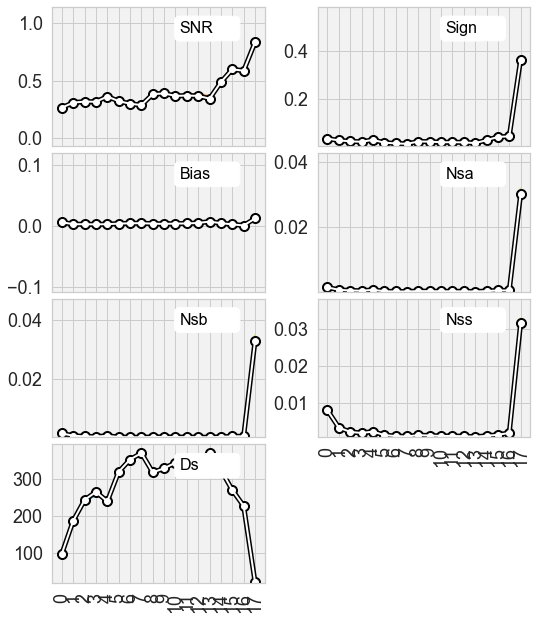

In [42]:
from src.plots import plot_SNR_summary

fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.25, hspace=0.05)
plot_SNR_summary(manifold_SNR, subj_cmap, plot_roi, perc_cutoff=25, fs=16)